In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from collections import OrderedDict

import ads

from mpl_utils import mpl_style

plt.style.use(mpl_style)

%matplotlib inline

In [2]:
def query_trend(keywords, years, filters=None, verbose=False):

    if isinstance(keywords, str):
        keywords = (keywords, )

    filters = "" if filters is None else " ".join(filters)
    
    percents = []
    for year in tqdm.tqdm(years):
        
        modifier = f"year:{year} {filters}"
        all_papers = ads.SearchQuery(q=modifier)
        all_papers.execute()

        count = 0
        for keyword in keywords:
            papers = ads.SearchQuery(q=f"full:\"{keyword}\" {modifier}")
            papers.execute()
            count += papers.response.numFound
        
        total = all_papers.response.numFound
        percent = 100 * count / float(total)
        percents.append(percent)
        
        if verbose:
            print(f"{year} '{keyword}' {count} / {total} ({percent:.2f}%)")

    return percents

In [6]:
languages = OrderedDict([
    ("IDL", ["IDL"]),
    ("Python", ["Python", "astropy"]),
    ("Matlab", ["Matlab", "MATLAB"]),
    ("Wolfram", ["Wolfram", "Mathematica"]),
    ("Julia", ["Julia"]),
    ("Figaro", ["Figaro"]),
    ("Jupyter", ["jupyter", "Jupyter"]), 
])

years = np.arange(2000, 2019)

kwds = dict(years=years,
            verbose=False,
            filters=("database:astronomy", "property:refereed"))

In [4]:
results = dict([(k, query_trend(v, **kwds)) for k, v in languages.items()])

100%|██████████| 19/19 [01:15<00:00,  3.97s/it]


/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['font.sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


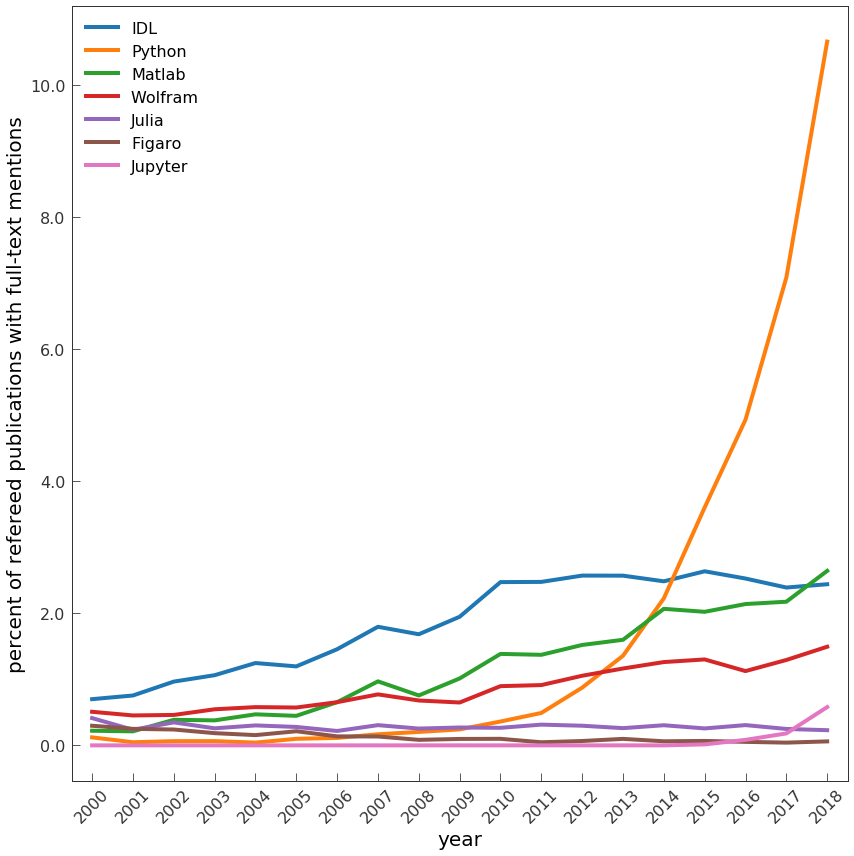

In [103]:
fontsize = 16

plt.rcParams["text.usetex"] = False
fig, ax = plt.subplots(figsize=(12, 12))
for key, percents in results.items():
    ax.plot(years, percents, "-", label=key, lw=4)

ax.set_xticks(years)
ax.set_xlim(years[0] - 0.5, 0.5 + years[-1])

legend = plt.legend(frameon=False, fontsize=fontsize)
ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize, rotation=45)
ax.set_yticklabels(ax.get_yticks(), fontsize=fontsize)
ax.set_ylabel(r"percent of refereed publications with full-text mentions",
              fontdict=dict(fontsize=20, family="font.sans-serif"))
ax.set_xlabel("year", fontdict=dict(size=20, family="font.sans-serif"))
fig.tight_layout()
fig.savefig("trends.png", dpi=300)

In [85]:
x = np.array(years)
y = results["Python"]
f = lambda x, *p: p[0] * p[1]**(x - p[2])
from scipy import optimize as op

p_opt, p_cov = op.curve_fit(f, x, y, p0=[0.5, 1, 1], maxfev=10000)


/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


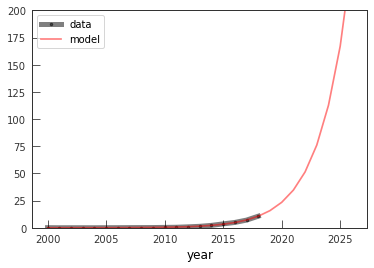

In [100]:
fig,  ax = plt.subplots()
ax.plot(x, y, c='k', alpha=0.5, lw=5, label="data")
xi = np.arange(2000, 2050)
yi = f(xi, *p_opt)

ylim_max = 200
idx = 1 + np.where(yi >= ylim_max)[0][0]
year = xi[idx]
ax.plot(xi[:idx], yi[:idx], "-", c='r', alpha=0.5, label="model")
ax.set_ylim(0, ylim_max)
plt.legend()
ax.set_xlabel("year")

In [101]:
print(f"Python will be used in {ylim_max}% of papers by {year}")

Python will be used in 200% of papers by 2027
